In [518]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

In [519]:
Data = pd.read_csv('train.csv')
Data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Split the Dataset to Train and Test Datasets

In [520]:
X, y = Data.iloc[:, :-1], Data.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 33)
FEData = pd.concat([X_train, y_train], axis = 1)
FEData.shape

(1095, 81)

## Feature Engineering For Numeric Features
Quick attempt to reduce the number of numeric features that can be added to the algorithm.

In [521]:
def CorrOfAvgTwo(NewVar, Var1, Var2):
    FEData[NewVar] = (FEData[Var1] + FEData[Var2])/2
    NewCorr = FEData.corr()
    return NewCorr['SalePrice'][['SalePrice', NewVar, Var1, Var2]]
def CorrOfSumTwo(NewVar, Var1, Var2):
    FEData[NewVar] = FEData[Var1] + FEData[Var2]
    NewCorr = FEData.corr()
    return NewCorr['SalePrice'][['SalePrice', NewVar, Var1, Var2]]
def CorrOfRatio(NewVar, Var1, Var2):
    FEData[NewVar] = (FEData[Var1]/FEData[Var2])*100
    NewCorr = FEData.corr()
    return NewCorr['SalePrice'][['SalePrice', NewVar, Var1, Var2]]

In [522]:
print(CorrOfAvgTwo('MedianBuiltYear', 'YearBuilt', 'YearRemodAdd')) # Pass
print(CorrOfRatio('BsmFinPct', 'BsmtFinSF1', 'TotalBsmtSF'))
print(CorrOfSumTwo('TotalFlrSF', '1stFlrSF', '2ndFlrSF')) # Pass
print(CorrOfRatio('GarageAreaPerCar', 'GarageArea', 'GarageCars'))
print(CorrOfRatio('WoodDeckSFPct', 'WoodDeckSF', 'OpenPorchSF'))
print(CorrOfRatio('PerRoomAreaAbvGrd', 'GrLivArea', 'TotRmsAbvGrd'))

SalePrice          1.000000
MedianBuiltYear    0.564656
YearBuilt          0.512793
YearRemodAdd       0.496781
Name: SalePrice, dtype: float64
SalePrice      1.000000
BsmFinPct      0.148978
BsmtFinSF1     0.416902
TotalBsmtSF    0.638119
Name: SalePrice, dtype: float64
SalePrice     1.000000
TotalFlrSF    0.726189
1stFlrSF      0.618983
2ndFlrSF      0.309192
Name: SalePrice, dtype: float64
SalePrice           1.000000
GarageAreaPerCar   -0.036357
GarageArea          0.616882
GarageCars          0.638119
Name: SalePrice, dtype: float64
SalePrice        1.000000
WoodDeckSFPct    0.172650
WoodDeckSF       0.322042
OpenPorchSF      0.323436
Name: SalePrice, dtype: float64
SalePrice            1.000000
PerRoomAreaAbvGrd    0.534782
GrLivArea            0.716671
TotRmsAbvGrd         0.523412
Name: SalePrice, dtype: float64


Only two of the new features worked.

## Create a Dataset That Includes Only the Filtered Features For the Algorithm 

In [523]:
FEData2 = FEData.copy()
FEData2['MedianBuiltYear'] = (FEData2['YearBuilt'] + FEData2['YearRemodAdd'])/2
FEData2['TotalFlrSF'] = FEData2['1stFlrSF'] + FEData2['2ndFlrSF']
FEData2['PerRoomAreaAbvGrd'] = (FEData2['GrLivArea']/FEData2['TotRmsAbvGrd'])*100                                                      

In [524]:
NewCorr = FEData2.corr()
NewCorr['SalePrice'][NewCorr['SalePrice'] > 0.5].sort_values(ascending = False)

SalePrice            1.000000
OverallQual          0.788424
TotalFlrSF           0.726189
GrLivArea            0.716671
TotalBsmtSF          0.638119
GarageCars           0.638119
1stFlrSF             0.618983
GarageArea           0.616882
MedianBuiltYear      0.564656
FullBath             0.549814
PerRoomAreaAbvGrd    0.534782
TotRmsAbvGrd         0.523412
YearBuilt            0.512793
Name: SalePrice, dtype: float64

Use features that have a correlation greater than 0.5 (with SalePrice) for the initial attempt for model building.
<br>
<br>
NOTE: *GrLivArea* is not included because it is highly correlated with *TotalFlrSF*. *GarageCars* is not inlcluded because it is highly correlated with *GarageArea*. *PerRoomAreaAbcGrd* is kept because it is NOT highly correlated with *TotRmsAbvGrd*. *YearBuilt* is not included because it is highly correlated with *MedianBuiltYear*.

In [525]:
NumAttributes = ['SalePrice', 'OverallQual', 'TotalFlrSF', 'TotalBsmtSF', 'GarageCars', 'MedianBuiltYear', 
                 'FullBath', 'PerRoomAreaAbvGrd', 'TotRmsAbvGrd'] 
FEData2[NumAttributes].corr()

,SalePrice,OverallQual,TotalFlrSF,TotalBsmtSF,GarageCars,MedianBuiltYear,FullBath,PerRoomAreaAbvGrd,TotRmsAbvGrd
SalePrice,1.000000,0.788424,0.726189,0.638119,0.638119,0.564656,0.549814,0.534782,0.523412
OverallQual,0.788424,1.000000,0.586060,0.528079,0.602322,0.626545,0.532548,0.479370,0.409838
TotalFlrSF,0.726189,0.586060,1.000000,0.418596,0.468784,0.252319,0.633057,0.639557,0.815116
TotalBsmtSF,0.638119,0.528079,0.418596,1.000000,0.457012,0.387283,0.319786,0.373533,0.249445
GarageCars,0.638119,0.602322,0.468784,0.457012,1.000000,0.555424,0.462497,0.360322,0.340000
MedianBuiltYear,0.564656,0.626545,0.252319,0.387283,0.555424,1.000000,0.504182,0.279747,0.121578
FullBath,0.549814,0.532548,0.633057,0.319786,0.462497,0.504182,1.000000,0.394494,0.534832
PerRoomAreaAbvGrd,0.534782,0.479370,0.639557,0.373533,0.360322,0.279747,0.394494,1.000000,0.115694
TotRmsAbvGrd,0.523412,0.409838,0.815116,0.249445,0.340000,0.121578,0.534832,0.115694,1.000000


## Feature Engineering For Categorical Features

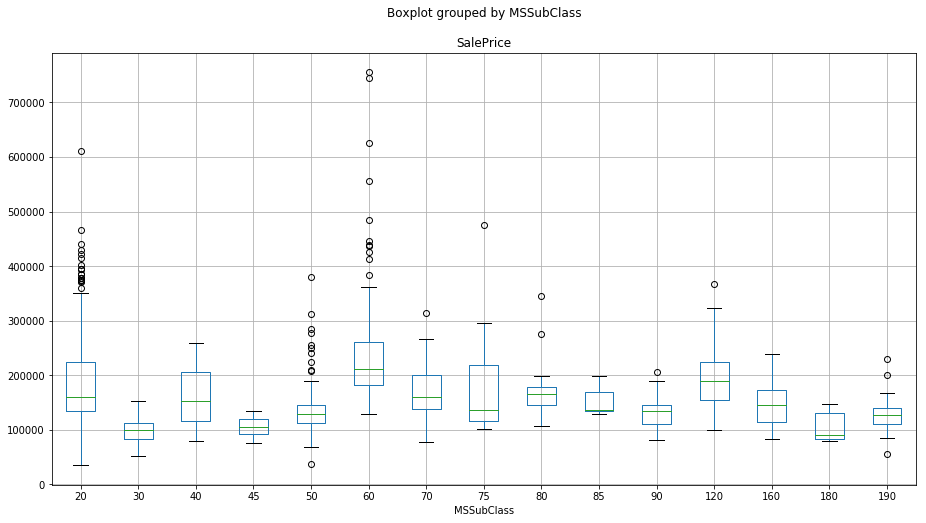

In [526]:
FEData.boxplot(column = 'SalePrice', by = 'MSSubClass', figsize = (15, 8))

In [527]:
def OneHotCorr(Var):
    TestData = FEData.copy()
    CatNum = len(TestData[Var].unique())
    TestData = pd.get_dummies(TestData, columns = [Var])
    TestCorr = TestData.corr()
    return TestCorr['SalePrice'][-CatNum:]

In [528]:
print(OneHotCorr('MSSubClass')) # MSSubClass_60: 2-STORY 1946 & NEWER = 0.36
print(OneHotCorr('MSZoning')) # MSZoning_RM: Residential Medium Density = -0.30
print(OneHotCorr('Street'))
print(OneHotCorr('Alley'))
print(OneHotCorr('LotShape'))
print(OneHotCorr('LandContour'))
print(OneHotCorr('Utilities'))
print(OneHotCorr('LotConfig'))
print(OneHotCorr('LandSlope'))
print(OneHotCorr('Neighborhood')) # Neighborhood_NoRidge: Northridge = 0.35 & Neighborhood_NridgHt: Northridge Heights = 0.38
print(OneHotCorr('Condition1'))
print(OneHotCorr('BldgType'))
print(OneHotCorr('HouseStyle'))
print(OneHotCorr('RoofStyle'))
print(OneHotCorr('RoofMatl'))
print(OneHotCorr('Exterior1st'))
print(OneHotCorr('MasVnrType')) # MasVnrType_None = -0.36 & MasVnrType_Stone = 0.33
print(OneHotCorr('Foundation')) # Foundation_CBlock: Cinder Block = -0.32 & Foundation_PConc: Poured Contrete = 0.48
print(OneHotCorr('Heating'))
print(OneHotCorr('CentralAir'))
print(OneHotCorr('Electrical'))
print(OneHotCorr('Functional'))
print(OneHotCorr('GarageType')) # GarageType_Attchd: Attached to home = 0.36 & GarageType_Detchd: Detached from home = -0.35
print(OneHotCorr('GarageFinish')) # GarageFinish_Fin: Finished = 0.44 & GarageFinish_Unf: Unfinished = -0.40
print(OneHotCorr('PavedDrive'))
print(OneHotCorr('MiscFeature'))
print(OneHotCorr('SaleType')) # SaleType_New: Home just constructed and sold = 0.35
print(OneHotCorr('SaleCondition')) # SaleCondition_Partial: Home was not completed when last assessed (associated with New Homes) = 0.34
print(OneHotCorr('BsmtQual')) # BsmtQual_Ex: Excellent = 0.56 & BsmtQual_TA: Average/Typical = -0.44
print(OneHotCorr('BsmtCond'))
print(OneHotCorr('BsmtExposure'))
print(OneHotCorr('BsmtFinType1')) # BsmtFinType1_GLQ: Good Living Quarters = 0.43
print(OneHotCorr('FireplaceQu')) # FireplaceQu_Gd: Good = 0.31
print(OneHotCorr('GarageQual'))
print(OneHotCorr('GarageCond'))
print(OneHotCorr('PoolQC'))
print(OneHotCorr('Fence'))

MSSubClass_20     0.065246
MSSubClass_30    -0.251093
MSSubClass_40    -0.010616
MSSubClass_45    -0.075860
MSSubClass_50    -0.167240
MSSubClass_60     0.356265
MSSubClass_70    -0.021255
MSSubClass_75     0.010373
MSSubClass_80    -0.034441
MSSubClass_85    -0.041158
MSSubClass_90    -0.117226
MSSubClass_120    0.054161
MSSubClass_160   -0.103951
MSSubClass_180   -0.069973
MSSubClass_190   -0.092989
Name: SalePrice, dtype: float64
MSZoning_C (all)   -0.098233
MSZoning_FV         0.095402
MSZoning_RH        -0.059539
MSZoning_RL         0.244181
MSZoning_RM        -0.298278
Name: SalePrice, dtype: float64
Street_Grvl   -0.026582
Street_Pave    0.026582
Name: SalePrice, dtype: float64
PerRoomAreaAbvGrd    0.534782
Alley_Grvl          -0.140142
Alley_Pave          -0.013823
Name: SalePrice, dtype: float64
LotShape_IR1    0.229826
LotShape_IR2    0.122231
LotShape_IR3    0.055048
LotShape_Reg   -0.276824
Name: SalePrice, dtype: float64
LandContour_Bnk   -0.095883
LandContour_HLS    0.083

In [529]:
def OrdinalVarCorr(Var):
    TestData = FEData.copy()
    OrderedRanking = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    TestData[Var] = TestData[Var].astype("category", ordered = True, categories=OrderedRanking).cat.codes
    TestCorr = TestData.corr()
    return TestCorr['SalePrice'][Var]

In [530]:
print(OrdinalVarCorr('ExterQual')) # Pass
print(OrdinalVarCorr('ExterCond'))
print(OrdinalVarCorr('HeatingQC')) # Pass
print(OrdinalVarCorr('KitchenQual')) # Pass

0.6639912161162248
0.01606458851722851
0.4191369692536453
0.6567493903576925


/Users/reesetou/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.


## Add Filtered Categorical Features Into the Dataset For the Algorithm

Only add those features that have a correlation greater than 0.5 for the initial attempt.

In [531]:
def OneHotCoding(Var, Dataset):
    Dataset = pd.get_dummies(Dataset, columns = [Var])
    return Dataset
def OrdinalCoding(Var, Dataset):
    OrderedRanking = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    Dataset[Var] = Dataset[Var].astype("category", ordered = True, categories=OrderedRanking).cat.codes
    return Dataset

In [532]:
FEData2 = OneHotCoding('BsmtQual', FEData2)

In [533]:
FEData2 = OrdinalCoding('ExterQual', FEData2)
FEData2 = OrdinalCoding('HeatingQC', FEData2)
FEData2 = OrdinalCoding('KitchenQual', FEData2)

/Users/reesetou/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [534]:
CatAttributes = ['BsmtQual_Ex', 'ExterQual', 'HeatingQC', 'KitchenQual']
AllAttributes = NumAttributes + CatAttributes
Attempt1Data = FEData2[AllAttributes]
Attempt1Data.head()

,SalePrice,OverallQual,TotalFlrSF,TotalBsmtSF,GarageCars,MedianBuiltYear,FullBath,PerRoomAreaAbvGrd,TotRmsAbvGrd,BsmtQual_Ex,ExterQual,HeatingQC,KitchenQual
779,135000,6,1004,975,2,1977.0,1,25100.000000,4,0,2,2,2
1335,167900,6,1334,1350,2,1977.0,2,22233.333333,6,0,2,2,2
62,202500,8,1370,1370,2,2006.0,2,22833.333333,6,0,3,4,3
450,110000,6,813,813,1,1967.5,1,16260.000000,5,0,2,4,3
600,275000,8,1904,1058,2,2005.0,2,23800.000000,8,0,3,4,4


## Prepare the Test Dataset

In [535]:
X_test2 = X_test.copy()
X_test2['MedianBuiltYear'] = (X_test2['YearBuilt'] + X_test2['YearRemodAdd'])/2
X_test2['TotalFlrSF'] = X_test2['1stFlrSF'] + X_test2['2ndFlrSF']
X_test2['PerRoomAreaAbvGrd'] = (X_test2['GrLivArea']/X_test2['TotRmsAbvGrd'])*100                                                      
X_test2 = OneHotCoding('BsmtQual', X_test2)
X_test2 = OrdinalCoding('ExterQual', X_test2)
X_test2 = OrdinalCoding('HeatingQC', X_test2)
X_test2 = OrdinalCoding('KitchenQual', X_test2)
AllAttributes.remove('SalePrice')
X_test2 = X_test2[AllAttributes]
X_test2.head()

/Users/reesetou/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


,OverallQual,TotalFlrSF,TotalBsmtSF,GarageCars,MedianBuiltYear,FullBath,PerRoomAreaAbvGrd,TotRmsAbvGrd,BsmtQual_Ex,ExterQual,HeatingQC,KitchenQual
753,8,2098,1030,3,2005.0,2,26225.000000,8,0,3,3,4
445,6,1689,1436,2,1956.0,1,24128.571429,7,0,2,1,2
1149,7,1482,650,2,1954.0,1,21171.428571,7,0,2,4,2
1300,7,1983,978,2,1999.0,2,22033.333333,9,0,3,4,3
1369,8,1668,1657,2,2003.0,2,20850.000000,8,0,3,4,3


In [536]:
y_train = Attempt1Data['SalePrice']
X_train = Attempt1Data.drop(['SalePrice'], axis = 1)

## Model Building Attempt #1

NOTE: Modeling building with features that have a correlation higher than 0.5 only.

In [537]:
lr = LinearRegression (normalize = True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test2)
RMSE = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print('Root Mean Square Error: ' + str(RMSE), ', R-square Score: ' + str(r2))

Root Mean Square Error: 45821.69069086682 , R-square Score: 0.6998735964625489


## Model Buiding Attempt #2

NOTE: Model building with features that have a correlation higher than 0.3.

In [538]:
FEData3 = FEData.copy()
FEData3['MedianBuiltYear'] = (FEData3['YearBuilt'] + FEData3['YearRemodAdd'])/2
FEData3['TotalFlrSF'] = FEData3['1stFlrSF'] + FEData3['2ndFlrSF']
FEData3['PerRoomAreaAbvGrd'] = (FEData3['GrLivArea']/FEData3['TotRmsAbvGrd'])*100  
NewCorr['SalePrice'][NewCorr['SalePrice'] > 0.3].sort_values(ascending = False)

SalePrice            1.000000
OverallQual          0.788424
TotalFlrSF           0.726189
GrLivArea            0.716671
TotalBsmtSF          0.638119
GarageCars           0.638119
1stFlrSF             0.618983
GarageArea           0.616882
MedianBuiltYear      0.564656
FullBath             0.549814
PerRoomAreaAbvGrd    0.534782
TotRmsAbvGrd         0.523412
YearBuilt            0.512793
YearRemodAdd         0.496781
Fireplaces           0.470784
MasVnrArea           0.470624
GarageYrBlt          0.469188
BsmtFinSF1           0.416902
LotFrontage          0.364449
OpenPorchSF          0.323436
WoodDeckSF           0.322042
2ndFlrSF             0.309192
Name: SalePrice, dtype: float64

In [539]:
NumAttributes2 = ['SalePrice', 'OverallQual', 'TotalFlrSF', 'TotalBsmtSF', 'GarageCars', 'MedianBuiltYear', 
                 'FullBath', 'PerRoomAreaAbvGrd', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'GarageYrBlt', 
                 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF'] 

In [540]:
FEData3 = OneHotCoding('MSSubClass', FEData3)
FEData3 = OneHotCoding('MSZoning', FEData3)
FEData3 = OneHotCoding('Neighborhood', FEData3)
FEData3 = OneHotCoding('MasVnrType', FEData3)
FEData3 = OneHotCoding('Foundation', FEData3)
FEData3 = OneHotCoding('GarageType', FEData3)
FEData3 = OneHotCoding('GarageFinish', FEData3)
FEData3 = OneHotCoding('SaleType', FEData3)
FEData3 = OneHotCoding('SaleCondition', FEData3)
FEData3 = OneHotCoding('BsmtQual', FEData3)
FEData3 = OneHotCoding('BsmtFinType1', FEData3)
FEData3 = OneHotCoding('FireplaceQu', FEData3)

In [541]:
FEData3 = OrdinalCoding('ExterQual', FEData3)
FEData3 = OrdinalCoding('HeatingQC', FEData3)
FEData3 = OrdinalCoding('KitchenQual', FEData3)

/Users/reesetou/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [542]:
CatAttributes2 = ['MSSubClass_60', 'MSZoning_RM', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'MasVnrType_None',
                 'MasVnrType_Stone', 'Foundation_CBlock', 'Foundation_PConc', 'GarageType_Attchd', 'GarageType_Detchd',
                 'GarageFinish_Fin', 'GarageFinish_Unf', 'SaleType_New', 'SaleCondition_Partial', 'BsmtQual_Ex',
                 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'FireplaceQu_Gd', 'ExterQual', 'HeatingQC', 'KitchenQual']
AllAttributes2 = NumAttributes2 + CatAttributes2
Attempt2Data = FEData3[AllAttributes2]
Attempt2Data.head()

,SalePrice,OverallQual,TotalFlrSF,TotalBsmtSF,GarageCars,MedianBuiltYear,FullBath,PerRoomAreaAbvGrd,TotRmsAbvGrd,Fireplaces,...,GarageFinish_Unf,SaleType_New,SaleCondition_Partial,BsmtQual_Ex,BsmtQual_TA,BsmtFinType1_GLQ,FireplaceQu_Gd,ExterQual,HeatingQC,KitchenQual
779,135000,6,1004,975,2,1977.0,1,25100.000000,4,0,...,1,0,0,0,0,1,0,2,2,2
1335,167900,6,1334,1350,2,1977.0,2,22233.333333,6,1,...,0,0,0,0,0,0,0,2,2,2
62,202500,8,1370,1370,2,2006.0,2,22833.333333,6,1,...,0,0,0,0,0,1,1,3,4,3
450,110000,6,813,813,1,1967.5,1,16260.000000,5,0,...,1,0,0,0,1,0,0,2,4,3
600,275000,8,1904,1058,2,2005.0,2,23800.000000,8,1,...,0,0,0,0,0,1,1,3,4,4


In [543]:
Attempt2Data = Attempt2Data.dropna()
y_train2 = Attempt2Data['SalePrice']
X_train2 = Attempt2Data.drop(['SalePrice'], axis = 1)

In [544]:
X_test3 = X_test.copy()
X_test3 = X_test3.fillna(X_test3.mean())
X_test3['MedianBuiltYear'] = (X_test3['YearBuilt'] + X_test3['YearRemodAdd'])/2
X_test3['TotalFlrSF'] = X_test3['1stFlrSF'] + X_test3['2ndFlrSF']
X_test3['PerRoomAreaAbvGrd'] = (X_test3['GrLivArea']/X_test3['TotRmsAbvGrd'])*100                                                      
X_test3 = OneHotCoding('MSSubClass', X_test3)
X_test3 = OneHotCoding('MSZoning', X_test3)
X_test3 = OneHotCoding('Neighborhood', X_test3)
X_test3 = OneHotCoding('MasVnrType', X_test3)
X_test3 = OneHotCoding('Foundation', X_test3)
X_test3 = OneHotCoding('GarageType', X_test3)
X_test3 = OneHotCoding('GarageFinish', X_test3)
X_test3 = OneHotCoding('SaleType', X_test3)
X_test3 = OneHotCoding('SaleCondition', X_test3)
X_test3 = OneHotCoding('BsmtQual', X_test3)
X_test3 = OneHotCoding('BsmtFinType1', X_test3)
X_test3 = OneHotCoding('FireplaceQu', X_test3)
X_test3 = OrdinalCoding('ExterQual', X_test3)
X_test3 = OrdinalCoding('HeatingQC', X_test3)
X_test3 = OrdinalCoding('KitchenQual', X_test3)
AllAttributes2.remove('SalePrice')
X_test3 = X_test3[AllAttributes2]
X_test3.head()

/Users/reesetou/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


,OverallQual,TotalFlrSF,TotalBsmtSF,GarageCars,MedianBuiltYear,FullBath,PerRoomAreaAbvGrd,TotRmsAbvGrd,Fireplaces,MasVnrArea,...,GarageFinish_Unf,SaleType_New,SaleCondition_Partial,BsmtQual_Ex,BsmtQual_TA,BsmtFinType1_GLQ,FireplaceQu_Gd,ExterQual,HeatingQC,KitchenQual
753,8,2098,1030,3,2005.0,2,26225.000000,8,1,178.0,...,0,0,0,0,0,0,1,3,3,4
445,6,1689,1436,2,1956.0,1,24128.571429,7,1,0.0,...,1,0,0,0,1,0,1,2,1,2
1149,7,1482,650,2,1954.0,1,21171.428571,7,0,0.0,...,1,0,0,0,1,0,0,2,4,2
1300,7,1983,978,2,1999.0,2,22033.333333,9,1,344.0,...,0,0,0,0,0,1,0,3,4,3
1369,8,1668,1657,2,2003.0,2,20850.000000,8,1,171.0,...,0,0,0,0,0,0,0,3,4,3


In [545]:
lr = LinearRegression (normalize = True)
lr.fit(X_train2, y_train2)
y_pred2 = lr.predict(X_test3)
RMSE2 = math.sqrt(mean_squared_error(y_test, y_pred2))
r22 = r2_score(y_test, y_pred2)
print('Root Mean Square Error: ' + str(RMSE2), ', R-square Score: ' + str(r22))

Root Mean Square Error: 45133.48142166673 , R-square Score: 0.7088212653183874


## Lesson Learned

- __train_test_split__ always happens before data cleaning and feature engineering so that it won't contaminate the results.
- Check and deal with NaN should be the very first step.
- More efficient functions and pipeline should be adopted in the future.
- Be careful with overwriting the dataset. Use __df.copy()__ instead of touching the original file.
- Simply adding more features into the model barely improved the model. More effort should be put into feature engineering or trying different models.